1)  Consider data set 1 (ds1.csv). The data set comprises features
(the Five xs) along with three sequences that may or may not be generated
from the features (3 ys).

a) Describe the data set in a few sentences.  E.g.   What are the
distributions of each feature?  Summary statistics?

b) Try to come up with a predictive model, e.g.  y = f(x_1 , … , x_n)
for each y sequence.   Describe your model and how you came up with
them.   What (if any) are the predictive variables?  How good would
you say each of your models is?

2) Consider data set 2 (ds2.csv).  The data asset comprises a set of
observations.

a) Describe the data set in a few sentences.

b) How would you visualize this data set?  Can you make an interesting
visualization?

c) Someone suggests that the observations are really from
multiple different files and were accidentally joined into one larger
data set.  Does anything about the data set suggest this?  If so, how
many different sources/file do you think there are?

d) Bonus points:  If you think there are more than one source in ds2,
can you assign each observation to the right source (based on the
number of sources you identified in 2c)?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
import operator
import warnings; warnings.simplefilter('ignore')
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel, pearsonr, mannwhitneyu, spearmanr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split,  cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [2]:
df1 = pd.read_csv('MLB-1.csv')
df2 = pd.read_csv('MLB-2.csv')

In [4]:
df1.head()

,Unnamed: 0,x1,x2,x3,x5,x6,ya,yb,yc
0,1,2.642583,-1.715220,1.909334,0.027139,-3.447187,13.630850,1.828765,0.008386
1,2,4.588761,-2.507543,4.239107,1.704150,-2.782809,7.834582,2.162110,0.000008
2,3,7.919796,-5.108415,3.039451,0.992815,5.551587,-5.107041,2.797083,-0.000005
3,4,2.616757,-2.124040,2.855570,0.990079,1.694697,19.015046,1.953887,0.038017
4,5,3.300856,-5.159684,0.764544,0.143581,3.277496,-9.818862,1.922446,0.001178


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
Unnamed: 0    100000 non-null int64
x1            100000 non-null float64
x2            100000 non-null float64
x3            100000 non-null float64
x5            100000 non-null float64
x6            100000 non-null float64
ya            100000 non-null float64
yb            100000 non-null float64
yc            100000 non-null float64
dtypes: float64(8), int64(1)
memory usage: 6.9 MB


# These are the summary statistics

In [6]:
df1.describe()

,Unnamed: 0,x1,x2,x3,x5,x6,ya,yb,yc
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,50000.500000,5.011059,-3.005565,2.500593,0.999136,0.000647,3.827867,2.111854,1.022765e-04
std,28867.657797,2.873568,2.000799,1.752906,1.002006,4.663860,18.438514,0.769306,3.121215e-02
min,1.000000,0.000015,-12.498524,-3.489212,0.000003,-13.885453,-64.021995,-0.523672,-5.433613e-01
25%,25000.750000,2.536309,-4.353844,1.189920,0.285629,-2.611943,-8.998020,1.580212,-2.423158e-03
50%,50000.500000,5.022191,-3.002649,2.503764,0.690903,-0.000611,2.666992,2.231057,-5.670000e-10
75%,75000.250000,7.486275,-1.649283,3.802236,1.386862,2.621841,15.579687,2.733318,2.476745e-03
max,100000.000000,9.999887,6.089820,8.679097,15.102966,13.924740,107.713997,3.841363,8.183882e-01


# These are the distributions:

- Unnamed is the index starting at 1
- x1 has an almost perfect continuous uniform / rectangular distribution. It has almost the same distribution as the index and only 2 variables share the same value.
- x2 and x3 are normally distributed
- x5 is an exponential distribution
- x6 has a Laplace / double exponential distribution
- ya is normal with a right skew... could be a Gumbel distribution
- yb is triangular distribution
- yc looks like a severe Laplace distribution

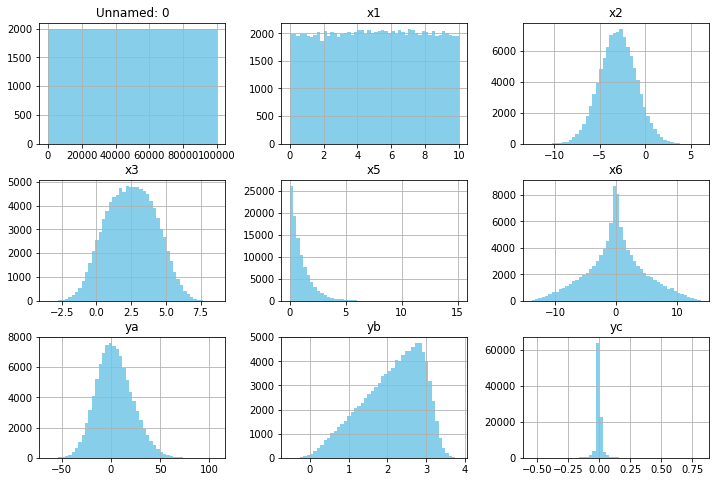

In [22]:
df1.hist(bins=50, figsize = (12,8), color = 'skyblue');

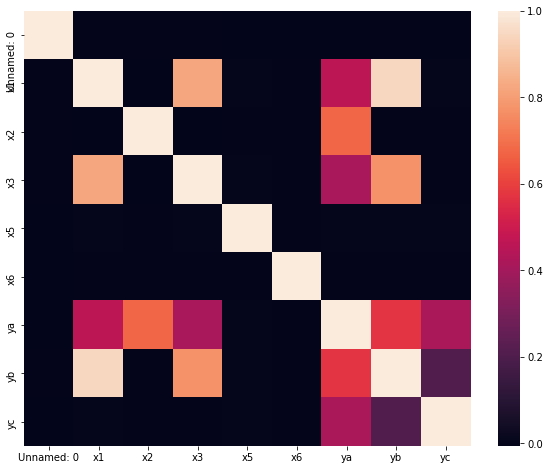

In [3]:
#heatmap of correlations

corr = df1.corr()
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

# Correlations: 
* ya has low to moderate correlation with x1, x2 and x3
* yb has high correlation with x1 and x3
* yc is only really correlated with other y-variables
* x1 and x3 are highly correlated, meaning they probably shouldn't be in a model together to avoid colinearity

In [4]:
#choosing features to model given the correlation heatmap above
#we're using all of the variables in yc because none of them are good

Xa = df1[['x1', 'x5', 'x6']]
Xb = df1[['x2', 'x5', 'x6']]
Xc = df1[['x1', 'x2', 'x5', 'x6']]

In [5]:
def regression_func(y, Xi):
    y = df1[y]                                          # set target
    X = Xi                                              #set values
    X = MinMaxScaler().fit_transform(X)                 #min max scale and test train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
                                                        #picking some regression functions
    models = [Ridge(),                                  #Ridge - linear models
          Lasso(),                                      #Lasso - linear models
          PassiveAggressiveRegressor(),                 #this works well with sparse data
          BaggingRegressor(),                           #Bagging is worth trying here
          AdaBoostRegressor(),                          #Adaptive Boosting
          RandomForestRegressor()                       #tree methods
         ]
     
    for model in models:
        print model
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        print score
        print " "

In [6]:
#applying the regression function to "a" set
#Ridge is the clear choice here

regression_func('ya', Xa)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
0.21575904144651661
 
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
0.18050950408610267
 
PassiveAggressiveRegressor(C=1.0, average=False, epsilon=0.1,
              fit_intercept=True, loss='epsilon_insensitive', max_iter=5,
              n_iter=None, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)
-0.02927373635881758
 
BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)
0.0782201753473416
 
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_st

In [7]:
#applying the regression function to "b" set
#Adaptive Boosting

regression_func('yb', Xb)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
-0.00010566516919707782
 
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
-4.1618537911070064e-05
 
PassiveAggressiveRegressor(C=1.0, average=False, epsilon=0.1,
              fit_intercept=True, loss='epsilon_insensitive', max_iter=5,
              n_iter=None, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)
-0.13438742485558786
 
BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)
0.3400925916372255
 
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, r

In [8]:
#applying the regression function to "c" set
#these are all terrible, the least terrible is Random Forest

regression_func('yc', Xc)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
-8.564021675128153e-05
 
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
-7.60471754013281e-07
 
PassiveAggressiveRegressor(C=1.0, average=False, epsilon=0.1,
              fit_intercept=True, loss='epsilon_insensitive', max_iter=5,
              n_iter=None, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)
-0.6111496685830158
 
BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)
-0.15170116906184838
 
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, ran

## Preferred Algorithms
ya: my preferred regressor for ya is Ridge as it has a R2 score of 0.216, Ridge includes a loss function and I prefer going with simple algorithms over more complex algorithms when possible as they are easy to interpret and less computationally involved.

yb: These are all pretty terrible. Adaptive Boosting is the best here with a score of 0.408.

yc: These are also all terrible. The least terrible is Random Forest with a score of -0.139. Though, after running the algorithm multiple times, the scores demonstrate tremendous variation, suggesting the instability of this model.

## Model Evaluation:
- ya is a mediocre model. 
- yb is bad.
- yc is terrible.

Since I don't know what the data actually represents, I can't *really* say if they are good or bad. I'd need more information.

# Dataframe 2

In [18]:
df2.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,1,23.778224,13.319974,15.565124,-3.713626,7.296793,-19.371013,-0.894130,-6.110282,-28.959316,2.851336
1,2,16.602950,23.311281,21.099052,-0.304154,-3.218990,2.357643,12.027277,7.070349,-5.762185,-23.050198
2,3,12.084683,19.710443,9.837102,-1.081918,-1.201942,9.738019,16.125920,19.119391,-15.582122,-12.292535
3,4,13.044534,10.749040,5.884407,-11.703525,-4.134358,-22.344666,-1.263349,0.493711,-15.305347,6.799087
4,5,8.314115,6.748794,5.388535,-0.000290,-4.724787,-16.346812,3.293600,-10.848273,-17.285491,6.034214


In [168]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
Unnamed: 0    2000 non-null int64
X1            2000 non-null float64
X2            2000 non-null float64
X3            2000 non-null float64
X4            2000 non-null float64
X5            2000 non-null float64
X6            2000 non-null float64
X7            2000 non-null float64
X8            2000 non-null float64
X9            2000 non-null float64
X10           2000 non-null float64
dtypes: float64(10), int64(1)
memory usage: 171.9 KB


In [169]:
df2.describe()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,8.677829,11.716801,9.252817,-2.679634,2.774942,0.077631,8.200884,8.712878,-12.860135,-1.339360
std,577.494589,11.971827,6.655333,9.861443,10.625164,8.800553,15.375478,10.426023,9.881482,8.881026,14.534143
min,1.000000,-25.824199,-8.497562,-23.666439,-29.429655,-22.033329,-35.264019,-21.428538,-16.811146,-36.065150,-36.468083
25%,500.750000,0.231327,7.161564,2.648845,-10.652694,-4.098043,-14.003670,-0.812888,1.480706,-19.430697,-13.216190
50%,1000.500000,12.754335,11.896021,11.422441,-2.631318,2.484416,1.500838,8.532535,9.628064,-14.417786,-2.094310
75%,1500.250000,17.364337,16.279210,16.503676,5.340314,9.660898,14.050512,17.138898,16.081044,-6.534142,10.561797
max,2000.000000,32.268570,32.909917,31.230550,26.422798,29.312010,31.727042,32.084297,36.847922,13.553705,32.641789


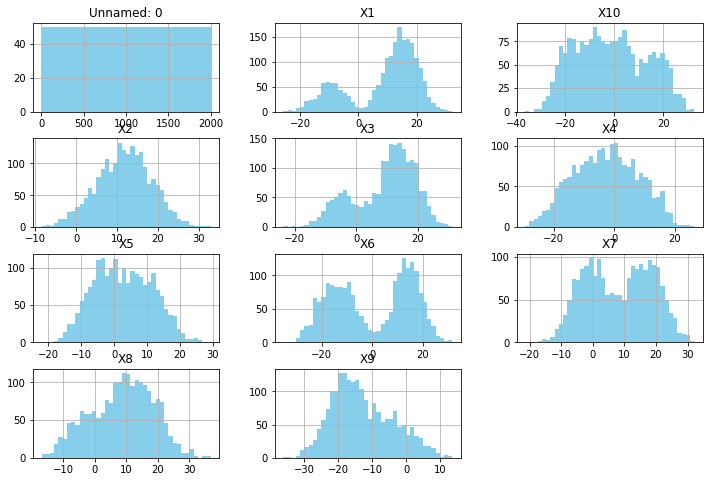

In [9]:
df2.hist(bins=40, figsize = (12,8), color = 'skyblue');

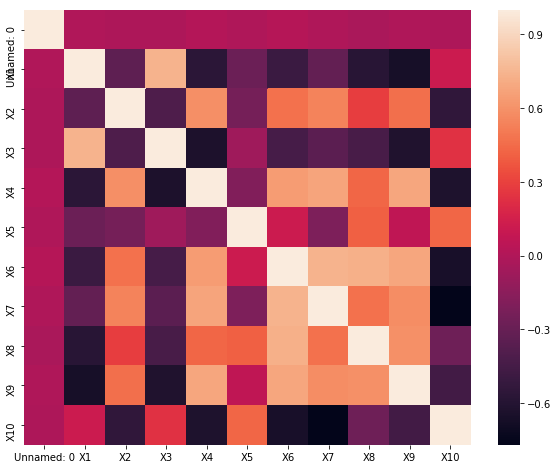

In [171]:
#x1 and x3 are positively correlated
#x2, x4, x6, x7, x8, x9 are positively correlated
#x1, x3 and x10 are strongly negatively correlated with every other column

corr = df2.corr()
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

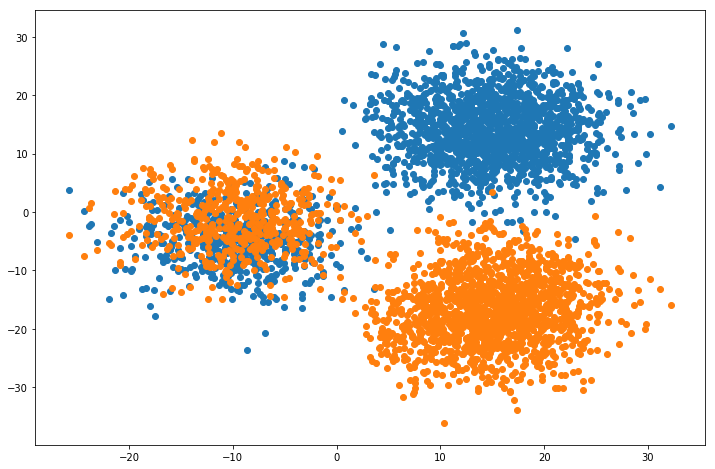

In [214]:
#let's look at the clustering with a scatterplot
#comparing positively and negatively correlated features with X1

plt.figure(figsize=(12,8))
plt.scatter(df2['X1'], df2['X3']);  #pos correlation = blue
plt.scatter(df2['X1'], df2['X9']);  #neg correlation = orange

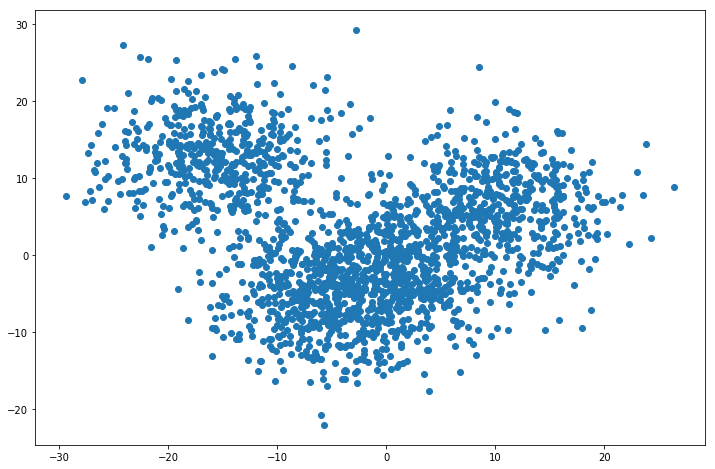

In [216]:
#let's look at the clustering with a scatterplot
#these aren't particularly correlated and are not bimodally distributed in the histogram 
#so it's interesting that they form 2 clusters here

plt.figure(figsize=(12,8))
plt.scatter(df2['X4'], df2['X5']); 

## Describe the data in a few sentences
This data is definitely noisier than df1. 4 of the 10 columns have bimodal distributions. While df1 looks like a computer-generated dataset, df2 looks like it might be a dataset the represents real data/observations/etc. The bimodally disriuted columns may be data that's aggregated from several datasets.
 
## How would you visualize this data set? Can you make an interesting visualization?
I think the distributions and correlations are interesting. Looking at scatterplots, there's a lot of clustering going on, with 2 clusters in most column arrangements, even those without bimodal distributions. You'd expect X1 and X3 to have 2 clusters, given their bimodal distributions, but not necessarily X4 and X5. This is interesting!

## Someone suggests that the observations are really from multiple different files and were accidentally joined into one larger data set. Does anything about the data set suggest this? If so, how many different sources/file do you think there are?
The bimodal distribution definitely suggests this. Perhaps the data is from 2 different data sources. It seems that most of the bimodal distributions are centered around zero. Also, looking at the correlations, it's possible that the positively and negatively correlated data come from the same source. 

## Bonus points: If you think there are more than one source in ds2, can you assign each observation to the right source (based on the number of sources you identified in 2c)?
You could apply a clustering algorithm--like K-Means--to the dataset for this purpose, setting k=2.